# Module Imports

Import the required modules for the following code.

In [1]:
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score 
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, RandomOverSampler

torch.manual_seed(0)

# Suppress warning from deprecation of functions down below
import warnings
warnings.simplefilter(action='ignore')
# warnings.filterwarnings("ignore", category=FutureWarning)


## 1. Data Loading and Preliminary Exploration

In [2]:
# Load client csv
client_dataset = pd.read_csv('./client.csv')

# Load invoice csv
invoice_dataset = pd.read_csv('./invoice.csv')

# Basic exploration

print(client_dataset.head())
print(invoice_dataset.head())
print(client_dataset.describe())
print(invoice_dataset.describe())

   region        date  dis                 id  catg  target
0     101  31/12/1994   60     train_Client_0    11       0
1     107   29/5/2002   69     train_Client_1    11       0
2     301   13/3/1986   62    train_Client_10    11       0
3     105   11/7/1996   69   train_Client_100    11       0
4     303  14/10/2014   62  train_Client_1000    11       0
               id        date  tarif_type  counter_number  counter_statue   
0  train_Client_0   24/3/2014          11       1335667.0               0  \
1  train_Client_0   29/3/2013          11       1335667.0               0   
2  train_Client_0   23/3/2015          11       1335667.0               0   
3  train_Client_0   13/7/2015          11       1335667.0               0   
4  train_Client_0  17/11/2016          11       1335667.0               0   

   counter_code  reading_remarque  consommation_level_4  old_index  new_index   
0           203                 8                     0      14302      14384  \
1           203

## 2. Data Cleaning

Provided dataset contains a lot of clients that does not have any information. Ideally, we would like to clean out the clients that does not have any information before working on the data itself.

In [3]:
# Load client csv
client_dataset = pd.read_csv('./client.csv')

# Load invoice csv
invoice_dataset = pd.read_csv('./invoice.csv')

# Retrieve client IDs with valid invoice data
unique_client_ids = invoice_dataset['id'].unique()

# Filter client dataset to contain only those with invoice information
filtered_client_dataset = client_dataset[client_dataset['id'].isin(unique_client_ids)].copy()

Thereafter, we would split the datasets into test and training sets for further processing in later stages

In [4]:
# split client by target
client_0 = filtered_client_dataset[filtered_client_dataset['target'] == 0]
client_1 = filtered_client_dataset[filtered_client_dataset['target'] == 1]

# random sample 10% of client_0
client_0_test = client_0.sample(frac=0.1, random_state=42)
client_0_train = client_0[client_0.index.isin(client_0_test.index) == False]

client_1_test = client_1.sample(frac=0.1, random_state=42)
client_1_train = client_1[client_1['id'].isin(client_1_test['id']) == False]

# merge by target
client_train = pd.concat([client_0_train, client_1_train])
client_test = pd.concat([client_0_test, client_1_test])


# split invoice by client id
invoice_train = invoice_dataset[invoice_dataset['id'].isin(client_train['id'])]
invoice_test = invoice_dataset[invoice_dataset['id'].isin(client_test['id'])]

# save to csv
client_train.to_csv('./client_train_split.csv', index=False)
client_test.to_csv('./client_test_split.csv', index=False)
invoice_train.to_csv('./invoice_train_split.csv', index=False)
invoice_test.to_csv('./invoice_test_split.csv', index=False)

# read client_train_split.csv
client_data_train = pd.read_csv('./client_train_split.csv')

# read invoice_train_split.csv
invoice_data_train = pd.read_csv('./invoice_train_split.csv')

# read client_test_split.csv
client_data_test = pd.read_csv('./client_test_split.csv')

# read invoice_test_split.csv
invoice_data_test = pd.read_csv('./invoice_test_split.csv')

## 3. Feature Engineering

The main purpose of the following feature engineering function is to transform the raw invoice data into a more informative and aggregated format. By creating aggregated features at the `client_id` level, the ffunction captures overall behaviour of each client over time.

Features engineered are as follow:

- Data type conversion

- Extraction of information like month, year etc from invoice date for processing.

- Aggregation of invoice data for each client to get the sum, mean, max, and min of consumption levels, old and new index, month number, etc.

The main purpose of the following feature engineering is to ensure the client data is in correct format for modelling, as well as creating new features that might capture patterns better than the original ones. This includes aggregating or binning certain features to capture higher-level patterns.

Features engineered are as follow:

- Data type conversion

- Binning of `region` to broader categories to create new feature `region_group`. This helps to capture patterns that are more evident at a higher level or aggregated level, than at a granular level

Let us define the following auxiliary helper functions to aid our processing of data better.

- `ranges` function: 

    Calculates the range and interquartile range (IQR). The IQR and range are measures of statistical dispersion, meaning they represent the spread of the data. The IQR measures the spread of the middle 50% of the data, while the range measures the spread of the entire dataset. These measures can be useful in understanding the variability of the data and can be particularly helpful in detecting outliers.

- `data_drop` function:

    Drops certain columns from the dataset. Columns being dropped have been identified as not useful based on domain knowledge, exploratory data analysis.



In [5]:
class TabularDataset(Dataset):
    """
    Define a pytorch dataset class that accepts a csv path
    Holds all data and implements a __getitem__ method to be used by
    Python generator object or other classes that need it
    """

    def __init__(self, client_path, invoice_path, checkpoint=None, is_training=False):
        with open(client_path, "r") as f:
            client_data = pd.read_csv(f)

        # Data Engineering on client data
        # Categorical to numerical
        client_data["catg"] = client_data["catg"].astype("category").astype("int")
        client_data["dis"] = client_data["dis"].astype("category").astype("int")
        client_data["region"] = client_data["region"].astype("category").astype("int")

        # client_data['region_group'] = client_data['region'].apply(lambda x: 100 if x < 100 else 390 if x > 390 else 300 if x > 300 else 200)
        # client_data['region_group'] = client_data['region_group'].astype('category').astype('int')
        # client_data.drop(columns=['dis','region'], inplace=True)

        client_data["date"] = pd.to_datetime(client_data["date"], format="%d/%m/%Y")
        client_data["join_time"] = (
            (2019 - client_data["date"].dt.year) * 12 - client_data["date"].dt.month
        ).astype(int)
        client_data = client_data.drop(["date"], axis=1)

        # Read invoice data

        with open(invoice_path, "r") as f:
            invoice_data = pd.read_csv(f)

        invoice_data["counter_statue"] = (
            invoice_data["counter_statue"].astype("category").cat.codes.astype("int")
        )
        invoice_data["counter_type"] = (
            invoice_data["counter_type"].astype("category").cat.codes.astype("int")
        )

        # Deriving information form the invoice dates
        invoice_data["date"] = pd.to_datetime(invoice_data["date"], format="%d/%m/%Y")
        invoice_data["invoice_month"] = invoice_data["date"].dt.month
        invoice_data["invoice_year"] = invoice_data["date"].dt.year

        invoice_data = invoice_data.drop(["date"], axis=1)

        # Index diff = consumption
        invoice_data["index_diff"] = (
            invoice_data["new_index"] - invoice_data["old_index"]
        )

        # Getting the sum of the 4 consumption levels
        invoice_data["total_consumption"] = invoice_data[
            [
                "consommation_level_1",
                "consommation_level_2",
                "consommation_level_3",
                "consommation_level_4",
            ]
        ].sum(axis=1)

        def rename_cols(cols, prefix):
            return [f"{col}_{prefix}" for col in cols]

        invoice_max = invoice_data.groupby("id").max().astype("int")
        invoice_max.columns = rename_cols(invoice_max.columns, "max")

        invoice_min = invoice_data.groupby("id").min().astype("int")
        invoice_min.columns = rename_cols(invoice_min.columns, "min")

        invoice_median = invoice_data.groupby("id").median().astype("int")
        invoice_median.columns = rename_cols(invoice_median.columns, "median")

        invoice_lower_quartile = invoice_data.groupby("id").quantile(0.25).astype("int")
        invoice_lower_quartile.columns = rename_cols(
            invoice_lower_quartile.columns, "lowerquartile"
        )

        invoice_upper_quartile = invoice_data.groupby("id").quantile(0.75).astype("int")
        invoice_upper_quartile.columns = rename_cols(
            invoice_upper_quartile.columns, "upperquartile"
        )

        invoice_std = invoice_data.groupby("id").std().notna().astype("int")
        invoice_std.columns = rename_cols(invoice_std.columns, "std")

        invoice_mean = invoice_data.groupby("id").mean().astype("int")
        invoice_mean.columns = rename_cols(invoice_mean.columns, "mean")

        invoice_combined = pd.concat(
            [
                invoice_max,
                invoice_min,
                invoice_mean,
                invoice_median,
                invoice_std,
                invoice_lower_quartile,
                invoice_upper_quartile,
            ],
            axis=1,
        )

        # Checking if numbers of the meter and the invoice are identical
        invoice_data["is_energy_equal"] = (
            invoice_data["total_consumption"] == invoice_data["index_diff"]
        )

        # Merge the two dataframes
        merged_data = pd.merge(client_data, invoice_combined, on="id", how="left")
        self.data = merged_data.drop(["id"], axis=1)

        # add ranges
        for col in self.data.columns:
            if "upperquartile" in col:
                self.data[col.replace("upperquartile", "iqr")] = (
                    self.data[col]
                    - self.data[col.replace("upperquartile", "lowerquartile")]
                )
            if "max" in col:
                self.data[col.replace("max", "range")] = (
                    self.data[col] - self.data[col.replace("max", "min")]
                )

        if is_training:
            # Separate the two classes
            data_class_0 = self.data[self.data["target"] == 0]
            data_class_1 = self.data[self.data["target"] == 1]

            # Upsample the minority class (class 1 in this case)
            data_class_1_upsampled = resample(
                data_class_1, replace=True, n_samples=len(data_class_0), random_state=69
            )

            # Combine the upsampled class 1 data with the original class 0 data
            self.data = pd.concat([data_class_0, data_class_1_upsampled])

        scaler = sk.preprocessing.StandardScaler()
        if is_training:
            self.label = self.data["target"]
            self.label = torch.tensor(self.label.values, dtype=torch.float32)
            self.data = self.data.drop(["target"], axis=1)
            self.data = scaler.fit_transform(self.data)
            self.data = torch.tensor(self.data, dtype=torch.float32)

        else:
            self.data = self.data.drop(["target"], axis=1)
            self.data = scaler.fit_transform(self.data)
            self.data = torch.tensor(self.data, dtype=torch.float32)

            # make self.label a tensor of zeros
            self.label = torch.zeros(self.data.shape[0], dtype=torch.float32)

        print(self.data.shape, self.label.shape)

    def size(self):
        num_feature = self.data.shape[1]
        num_class = 1
        return num_feature, num_class

    def __len__(self):
        """
        Return number of instances in the data
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Args:
            idx: index of instance we want to get
        """
        # get row of data from tensor

        features = self.data[idx]
        label = self.label[idx]
        return features, label

## 4. Data Preprocessing

Before creating the model, let us do the final steps of processing our data, prepping the data as input to our model.

Given that this is a fraud detection problem, it's likely that the dataset is imbalanced (i.e., many more non-fraudulent than fraudulent transactions) and in our dataset, it is this very case. 

Here, we would consider 2 possible methods to address the imbalanced dataset issue.

- SMOTE to handle the class imbalance. SMOTE generates synthetic samples in the feature space.

- RandomOverSampler to handle class imbalance. RandomOverSamplper simply replicates some of the instances of the minority class at random.

In [6]:
class SMOTETabularDataset(Dataset):
    """
    Define a pytorch dataset class that accepts a csv path
    Holds all data and implements a __getitem__ method to be used by
    Python generator object or other classes that need it
    """

    def __init__(self, client_path, invoice_path, checkpoint=None, is_training=False):
        with open(client_path, "r") as f:
            client_data = pd.read_csv(f)

        # Data Engineering on client data
        # Categorical to numerical
        client_data["catg"] = client_data["catg"].astype("category").astype("int")
        client_data["dis"] = client_data["dis"].astype("category").astype("int")
        client_data["region"] = client_data["region"].astype("category").astype("int")

        # client_data['region_group'] = client_data['region'].apply(lambda x: 100 if x < 100 else 390 if x > 390 else 300 if x > 300 else 200)
        # client_data['region_group'] = client_data['region_group'].astype('category').astype('int')
        # client_data.drop(columns=['dis','region'], inplace=True)

        client_data["date"] = pd.to_datetime(client_data["date"], format="%d/%m/%Y")
        client_data["join_time"] = (
            (2019 - client_data["date"].dt.year) * 12 - client_data["date"].dt.month
        ).astype(int)
        client_data = client_data.drop(["date"], axis=1)

        # Read invoice data

        with open(invoice_path, "r") as f:
            invoice_data = pd.read_csv(f)

        invoice_data["counter_statue"] = (
            invoice_data["counter_statue"].astype("category").cat.codes.astype("int")
        )
        invoice_data["counter_type"] = (
            invoice_data["counter_type"].astype("category").cat.codes.astype("int")
        )

        # Deriving information form the invoice dates
        invoice_data["date"] = pd.to_datetime(invoice_data["date"], format="%d/%m/%Y")
        invoice_data["invoice_month"] = invoice_data["date"].dt.month
        invoice_data["invoice_year"] = invoice_data["date"].dt.year

        invoice_data = invoice_data.drop(["date"], axis=1)

        # Index diff = consumption
        invoice_data["index_diff"] = (
            invoice_data["new_index"] - invoice_data["old_index"]
        )

        # Getting the sum of the 4 consumption levels
        invoice_data["total_consumption"] = invoice_data[
            [
                "consommation_level_1",
                "consommation_level_2",
                "consommation_level_3",
                "consommation_level_4",
            ]
        ].sum(axis=1)

        def rename_cols(cols, prefix):
            return [f"{col}_{prefix}" for col in cols]

        invoice_max = invoice_data.groupby("id").max().astype("int")
        invoice_max.columns = rename_cols(invoice_max.columns, "max")

        invoice_min = invoice_data.groupby("id").min().astype("int")
        invoice_min.columns = rename_cols(invoice_min.columns, "min")

        invoice_median = invoice_data.groupby("id").median().astype("int")
        invoice_median.columns = rename_cols(invoice_median.columns, "median")

        invoice_lower_quartile = invoice_data.groupby("id").quantile(0.25).astype("int")
        invoice_lower_quartile.columns = rename_cols(
            invoice_lower_quartile.columns, "lowerquartile"
        )

        invoice_upper_quartile = invoice_data.groupby("id").quantile(0.75).astype("int")
        invoice_upper_quartile.columns = rename_cols(
            invoice_upper_quartile.columns, "upperquartile"
        )

        invoice_std = invoice_data.groupby("id").std().notna().astype("int")
        invoice_std.columns = rename_cols(invoice_std.columns, "std")

        invoice_mean = invoice_data.groupby("id").mean().astype("int")
        invoice_mean.columns = rename_cols(invoice_mean.columns, "mean")

        invoice_combined = pd.concat(
            [
                invoice_max,
                invoice_min,
                invoice_mean,
                invoice_median,
                invoice_std,
                invoice_lower_quartile,
                invoice_upper_quartile,
            ],
            axis=1,
        )

        # Checking if numbers of the meter and the invoice are identical
        invoice_data["is_energy_equal"] = (
            invoice_data["total_consumption"] == invoice_data["index_diff"]
        )

        # Merge the two dataframes
        merged_data = pd.merge(client_data, invoice_combined, on="id", how="left")
        self.data = merged_data.drop(["id"], axis=1)

        # add ranges
        for col in self.data.columns:
            if "upperquartile" in col:
                self.data[col.replace("upperquartile", "iqr")] = (
                    self.data[col]
                    - self.data[col.replace("upperquartile", "lowerquartile")]
                )
            if "max" in col:
                self.data[col.replace("max", "range")] = (
                    self.data[col] - self.data[col.replace("max", "min")]
                )

        scaler = sk.preprocessing.StandardScaler()
        if is_training:
            # SMOTE Resample
            smote = SMOTE(sampling_strategy='auto', random_state=42)
            self.label = self.data["target"]
            self.data = self.data.drop(["target"], axis=1)
            self.data, self.label = smote.fit_resample(self.data, self.label)
            self.label = torch.tensor(self.label.values, dtype=torch.float32)
            self.data = scaler.fit_transform(self.data)
            self.data = torch.tensor(self.data, dtype=torch.float32)

        else:
            self.data = self.data.drop(["target"], axis=1)
            self.data = scaler.fit_transform(self.data)
            self.data = torch.tensor(self.data, dtype=torch.float32)

            # make self.label a tensor of zeros
            self.label = torch.zeros(self.data.shape[0], dtype=torch.float32)

        print(self.data.shape, self.label.shape)

    def size(self):
        num_feature = self.data.shape[1]
        num_class = 1
        return num_feature, num_class

    def __len__(self):
        """
        Return number of instances in the data
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Args:
            idx: index of instance we want to get
        """
        # get row of data from tensor

        features = self.data[idx]
        label = self.label[idx]
        return features, label

In [7]:
class RandomOverSamplerTabularDataset(Dataset):
    """
    Define a pytorch dataset class that accepts a csv path
    Holds all data and implements a __getitem__ method to be used by
    Python generator object or other classes that need it
    """

    def __init__(self, client_path, invoice_path, checkpoint=None, is_training=False):
        with open(client_path, "r") as f:
            client_data = pd.read_csv(f)

        # Data Engineering on client data
        # Categorical to numerical
        client_data["catg"] = client_data["catg"].astype("category").astype("int")
        client_data["dis"] = client_data["dis"].astype("category").astype("int")
        client_data["region"] = client_data["region"].astype("category").astype("int")

        # client_data['region_group'] = client_data['region'].apply(lambda x: 100 if x < 100 else 390 if x > 390 else 300 if x > 300 else 200)
        # client_data['region_group'] = client_data['region_group'].astype('category').astype('int')
        # client_data.drop(columns=['dis','region'], inplace=True)

        client_data["date"] = pd.to_datetime(client_data["date"], format="%d/%m/%Y")
        client_data["join_time"] = (
            (2019 - client_data["date"].dt.year) * 12 - client_data["date"].dt.month
        ).astype(int)
        client_data = client_data.drop(["date"], axis=1)

        # Read invoice data

        with open(invoice_path, "r") as f:
            invoice_data = pd.read_csv(f)

        invoice_data["counter_statue"] = (
            invoice_data["counter_statue"].astype("category").cat.codes.astype("int")
        )
        invoice_data["counter_type"] = (
            invoice_data["counter_type"].astype("category").cat.codes.astype("int")
        )

        # Deriving information form the invoice dates
        invoice_data["date"] = pd.to_datetime(invoice_data["date"], format="%d/%m/%Y")
        invoice_data["invoice_month"] = invoice_data["date"].dt.month
        invoice_data["invoice_year"] = invoice_data["date"].dt.year

        invoice_data = invoice_data.drop(["date"], axis=1)

        # Index diff = consumption
        invoice_data["index_diff"] = (
            invoice_data["new_index"] - invoice_data["old_index"]
        )

        # Getting the sum of the 4 consumption levels
        invoice_data["total_consumption"] = invoice_data[
            [
                "consommation_level_1",
                "consommation_level_2",
                "consommation_level_3",
                "consommation_level_4",
            ]
        ].sum(axis=1)

        def rename_cols(cols, prefix):
            return [f"{col}_{prefix}" for col in cols]

        invoice_max = invoice_data.groupby("id").max().astype("int")
        invoice_max.columns = rename_cols(invoice_max.columns, "max")

        invoice_min = invoice_data.groupby("id").min().astype("int")
        invoice_min.columns = rename_cols(invoice_min.columns, "min")

        invoice_median = invoice_data.groupby("id").median().astype("int")
        invoice_median.columns = rename_cols(invoice_median.columns, "median")

        invoice_lower_quartile = invoice_data.groupby("id").quantile(0.25).astype("int")
        invoice_lower_quartile.columns = rename_cols(
            invoice_lower_quartile.columns, "lowerquartile"
        )

        invoice_upper_quartile = invoice_data.groupby("id").quantile(0.75).astype("int")
        invoice_upper_quartile.columns = rename_cols(
            invoice_upper_quartile.columns, "upperquartile"
        )

        invoice_std = invoice_data.groupby("id").std().notna().astype("int")
        invoice_std.columns = rename_cols(invoice_std.columns, "std")

        invoice_mean = invoice_data.groupby("id").mean().astype("int")
        invoice_mean.columns = rename_cols(invoice_mean.columns, "mean")

        invoice_combined = pd.concat(
            [
                invoice_max,
                invoice_min,
                invoice_mean,
                invoice_median,
                invoice_std,
                invoice_lower_quartile,
                invoice_upper_quartile,
            ],
            axis=1,
        )

        # Checking if numbers of the meter and the invoice are identical
        invoice_data["is_energy_equal"] = (
            invoice_data["total_consumption"] == invoice_data["index_diff"]
        )

        # Merge the two dataframes
        merged_data = pd.merge(client_data, invoice_combined, on="id", how="left")
        self.data = merged_data.drop(["id"], axis=1)

        # add ranges
        for col in self.data.columns:
            if "upperquartile" in col:
                self.data[col.replace("upperquartile", "iqr")] = (
                    self.data[col]
                    - self.data[col.replace("upperquartile", "lowerquartile")]
                )
            if "max" in col:
                self.data[col.replace("max", "range")] = (
                    self.data[col] - self.data[col.replace("max", "min")]
                )

        scaler = sk.preprocessing.StandardScaler()
        if is_training:
            # RandomOverSampler Approach
            self.label = self.data["target"]
            self.data = self.data.drop(["target"], axis=1)
            self.data, self.label = RandomOverSampler(random_state=1234).fit_resample(self.data, self.label)
            self.label = torch.tensor(self.label.values, dtype=torch.float32)
            self.data = scaler.fit_transform(self.data)
            self.data = torch.tensor(self.data, dtype=torch.float32)

        else:
            self.data = self.data.drop(["target"], axis=1)
            self.data = scaler.fit_transform(self.data)
            self.data = torch.tensor(self.data, dtype=torch.float32)

            # make self.label a tensor of zeros
            self.label = torch.zeros(self.data.shape[0], dtype=torch.float32)

        print(self.data.shape, self.label.shape)

    def size(self):
        num_feature = self.data.shape[1]
        num_class = 1
        return num_feature, num_class

    def __len__(self):
        """
        Return number of instances in the data
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Args:
            idx: index of instance we want to get
        """
        # get row of data from tensor

        features = self.data[idx]
        label = self.label[idx]
        return features, label

## 5. Model Building

In [8]:
class Model(nn.Module):
    """
    Define a logistic regression model
    """

    def __init__(self, num_features, num_class=1):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(num_features, 64),
            nn.ReLU(),
            # nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            # nn.Dropout(0.1),
            nn.Linear(32, 16),
            nn.ReLU(),
            # nn.Dropout(0.1),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )


    def forward(self, input):
        outputs = self.linear(input)
        return outputs


def collator_train(batch):
    """
    Defining a collator batch might not be necessary in our case,
    if dataset is already good we have no use for it
    """
    features_list = []
    label_list = []
    for instance in batch:
        features_list.append(instance[0])
        label_list.append(instance[1])

    features = torch.stack(features_list)

    labels = torch.stack(label_list)
    return features, labels
    

def collator_test(batch):
    """
    Defining a collator batch might not be necessary in our case,
    if dataset is already good we have no use for it
    """
    features_list = []
    label_list = []
    for instance in batch:
        features_list.append(instance[0])
        label_list.append(instance[1])

    features = torch.stack(features_list)

    return features


def train(
    model, dataset, batch_size, learning_rate, num_epoch, device="cuda", model_path=None
):
    data_loader = DataLoader(
        dataset, batch_size=batch_size, collate_fn=collator_train, shuffle=True
    )

    # Loss Function and Optimizer declared here
    # Criterion, cross entropy used as an example for now
    loss_function = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    start = datetime.datetime.now()  # To be used to know how fast our model take to run

    for epoch in range(num_epoch):
        model.train()
        running_loss = 0.0
        for step, data in enumerate(data_loader, 0):
            # Get the inputs, tuple of (inputs, labels)
            features = data[0].to(device)
            labels = data[1].to(device)

            # Zeroing the parameter gradients
            model.zero_grad()

            # Forward propogation
            predictions = model(features)

            # Loss calculation
            predictions = torch.squeeze(predictions)
            loss = loss_function(predictions, labels)

            # do backpropogation
            loss.backward()

            # Parameter optimization step
            optimizer.step()

            # calculate running loss value for non padding
            running_loss += loss.item()

            if step % 100 == 99:
                print(
                    "[%d, %5d] loss: %.3f" % (epoch + 1, step + 1, running_loss / 100)
                )
                running_loss = 0.0

    end = datetime.datetime.now()

    # Checkpoint to save model and any useful information that we will require for testing
    checkpoint = {
        "model_state_dic": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "dataset": dataset.data,
    }
    torch.save(checkpoint, model_path)

    print("Model saved in ", model_path)
    print("Training finished in {} minutes.".format((end - start).seconds / 60.0))

In [9]:
if torch.cuda.is_available():
    device_str = "cuda:{}".format(0)
else:
    device_str = "cpu"

device = torch.device(device_str)

dataset = TabularDataset('./client_train_split.csv', './invoice_train_split.csv', is_training=True)
smote_dataset = SMOTETabularDataset('./client_train_split.csv', './invoice_train_split.csv', is_training=True)
ros_dataset = RandomOverSamplerTabularDataset('./client_train_split.csv', './invoice_train_split.csv', is_training=True)

num_feature, num_class = dataset.size()
model = Model(num_feature, num_class).to(device)

smote_num_feature, smote_num_class = smote_dataset.size()
smote_model = Model(smote_num_feature, smote_num_class).to(device)

ros_num_feature, ros_num_class = ros_dataset.size()
ros_model = Model(ros_num_feature, ros_num_class).to(device)

# you may change these hyper-parameters
learning_rate = 0.001
batch_size = 50
num_epochs = 100

train(
    model,
    dataset,
    batch_size,
    learning_rate,
    num_epochs,
    device,
    "mlp.pt",
)

# SMOTE Model
train(
    smote_model,
    smote_dataset,
    batch_size,
    learning_rate,
    num_epochs,
    device,
    "smote_mlp.pt",
)

# ROS Model
train(
    ros_model,
    ros_dataset,
    batch_size,
    learning_rate,
    num_epochs,
    device,
    "ros_mlp.pt",
)

torch.Size([53722, 166]) torch.Size([53722])
torch.Size([53722, 166]) torch.Size([53722])
torch.Size([53722, 166]) torch.Size([53722])
[1,   100] loss: 0.694
[1,   200] loss: 0.694
[1,   300] loss: 0.693
[1,   400] loss: 0.693
[1,   500] loss: 0.693
[1,   600] loss: 0.693
[1,   700] loss: 0.692
[1,   800] loss: 0.692
[1,   900] loss: 0.692
[1,  1000] loss: 0.692
[2,   100] loss: 0.691
[2,   200] loss: 0.691
[2,   300] loss: 0.691
[2,   400] loss: 0.690
[2,   500] loss: 0.690
[2,   600] loss: 0.690
[2,   700] loss: 0.690
[2,   800] loss: 0.690
[2,   900] loss: 0.689
[2,  1000] loss: 0.690
[3,   100] loss: 0.689
[3,   200] loss: 0.689
[3,   300] loss: 0.688
[3,   400] loss: 0.689
[3,   500] loss: 0.688
[3,   600] loss: 0.687
[3,   700] loss: 0.687
[3,   800] loss: 0.687
[3,   900] loss: 0.687
[3,  1000] loss: 0.687
[4,   100] loss: 0.686
[4,   200] loss: 0.686
[4,   300] loss: 0.686
[4,   400] loss: 0.686
[4,   500] loss: 0.685
[4,   600] loss: 0.685
[4,   700] loss: 0.685
[4,   800] los

KeyboardInterrupt: 

## 6. Evaluation

In [ ]:
def test(model, dataset, device="cuda"):
    model.eval()
    data_loader = DataLoader(dataset, batch_size=20, collate_fn=collator_test, shuffle=False)
    prob_labels = []
    labels = []
    with torch.no_grad():
        for data in data_loader:
            features = data.to(device)
            output = model(features)

            for tensor in output:
                prob_labels.append(tensor.item())
                # Set threshold for binary output
                binary_output = 1 if tensor.item() >= 0.8 else 0
                labels.append(binary_output)

    return prob_labels, labels

checkpoint = torch.load("mlp.pt")
checkpoint_smote = torch.load("smote_mlp.pt")
checkpoint_ros = torch.load("ros_mlp.pt")

# create the test dataset object using LangDataset class
dataset = TabularDataset(
    './client_test_split.csv',
    './invoice_test_split.csv',
    checkpoint["dataset"],
    is_training=False,
)
num_vocab, num_class = dataset.size()

smote_dataset = SMOTETabularDataset(
    './client_test_split.csv',
    './invoice_test_split.csv',
    checkpoint["dataset"],
    is_training=False,
)
smote_num_vocab, smote_num_class = dataset.size()

ros_dataset = RandomOverSamplerTabularDataset(
    './client_test_split.csv',
    './invoice_test_split.csv',
    checkpoint["dataset"],
    is_training=False,
)
ros_num_vocab, ros_num_class = dataset.size()

# initialize and load the model
model = Model(num_vocab, num_class).to(device)
model.load_state_dict(checkpoint["model_state_dic"])

smote_model = Model(smote_num_vocab, smote_num_class).to(device)
smote_model.load_state_dict(checkpoint_smote["model_state_dic"])

ros_model = Model(ros_num_vocab, ros_num_class).to(device)
ros_model.load_state_dict(checkpoint_ros["model_state_dic"])

# Grab client_id to put into submission CSV
test_client_ids = pd.read_csv('./client_test_split.csv')["id"].tolist()

# run the prediction
y_prob, y_pred = test(model, dataset, device)
y_prob_smote, y_pred_smote = test(smote_model, dataset, device)
y_prob_ros, y_pred_ros = test(ros_model, dataset, device)


# print(len(y_pred), len(test_client_ids))
# write the output
# data_dict = {"id": test_client_ids, "target": y_pred}
# output = pd.DataFrame(data_dict)
# output.to_csv('model_output.csv', index=False)

torch.Size([3161, 166]) torch.Size([3161])
torch.Size([3161, 166]) torch.Size([3161])
torch.Size([3161, 166]) torch.Size([3161])


We evaluate the 2 models using various metrics like accuracy, precision, recall, F1 score, and ROC AUC score. Given that this is a fraud detection problem, metrics like precision, recall, and F1 score are particularly important because they give us insights into the model's performance on the positive (fraud) class.

Accuracy: 0.8788358114520721
Precision: 0.2210242587601078
Recall: 0.4659090909090909
F1 Score: 0.29981718464351004
F2 Score: 0.38139534883720927
ROC AUC Score: 0.68454583523679
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      2985
           1       0.22      0.47      0.30       176

    accuracy                           0.88      3161
   macro avg       0.59      0.68      0.62      3161
weighted avg       0.92      0.88      0.90      3161



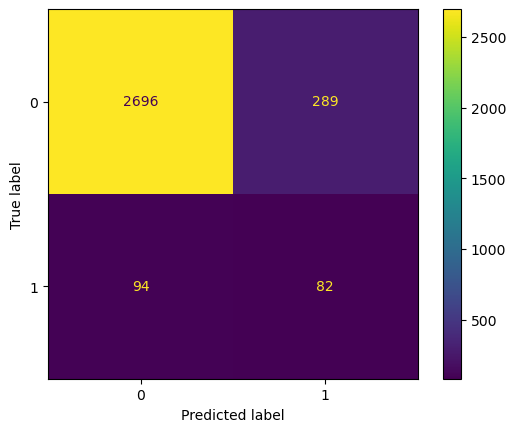

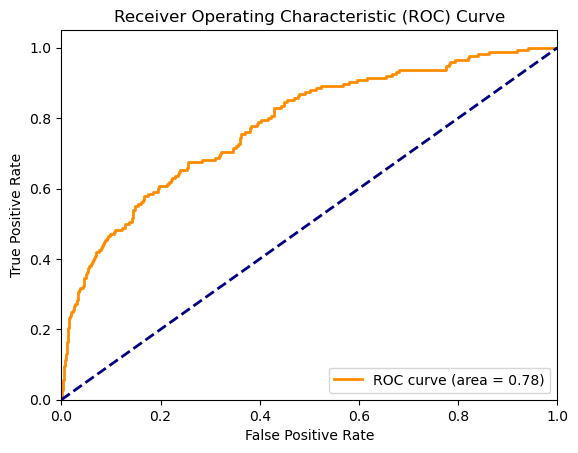

In [ ]:
client_data_test = pd.read_csv('./client_test_split.csv')
y_test = client_data_test['target']

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("F2 Score:", fbeta_score(y_test, y_pred, beta=2))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

# Print Classification Report
print(classification_report(y_test, y_pred))

# For better visualisation
# 1. Plotting the Confusion Matrix
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

# 2. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### SMOTE Evaluation

Accuracy: 0.609617209743752
Precision: 0.08928571428571429
Recall: 0.6534090909090909
F1 Score: 0.15710382513661203
F2 Score: 0.2886546184738956
ROC AUC Score: 0.6302221333942439
              precision    recall  f1-score   support

           0       0.97      0.61      0.75      2985
           1       0.09      0.65      0.16       176

    accuracy                           0.61      3161
   macro avg       0.53      0.63      0.45      3161
weighted avg       0.92      0.61      0.71      3161



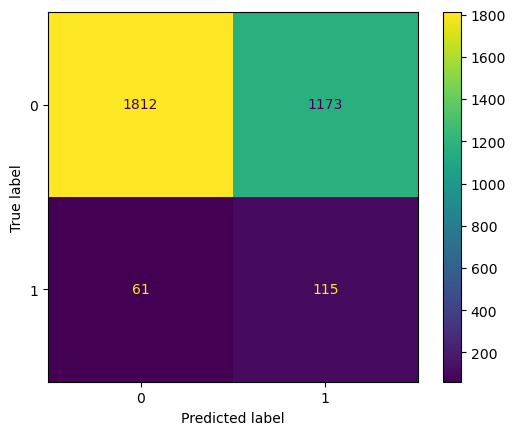

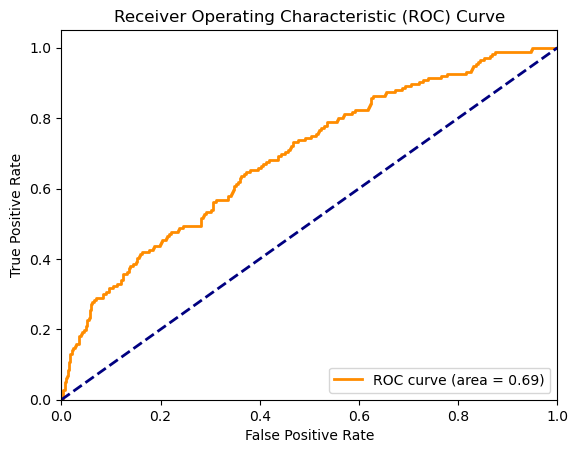

In [ ]:
client_data_test = pd.read_csv('./client_test_split.csv')
y_test = client_data_test['target']

print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print("Precision:", precision_score(y_test, y_pred_smote))
print("Recall:", recall_score(y_test, y_pred_smote))
print("F1 Score:", f1_score(y_test, y_pred_smote))
print("F2 Score:", fbeta_score(y_test, y_pred_smote, beta=2))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_smote))

# Print Classification Report
print(classification_report(y_test, y_pred_smote))

# For better visualisation
# 1. Plotting the Confusion Matrix
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_smote)

# 2. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_smote)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### RandomOverSampler Evaluation

Accuracy: 0.8633343878519456
Precision: 0.19082125603864733
Recall: 0.44886363636363635
F1 Score: 0.2677966101694915
F2 Score: 0.35330948121645794
ROC AUC Score: 0.668317915334247
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      2985
           1       0.19      0.45      0.27       176

    accuracy                           0.86      3161
   macro avg       0.58      0.67      0.60      3161
weighted avg       0.92      0.86      0.89      3161



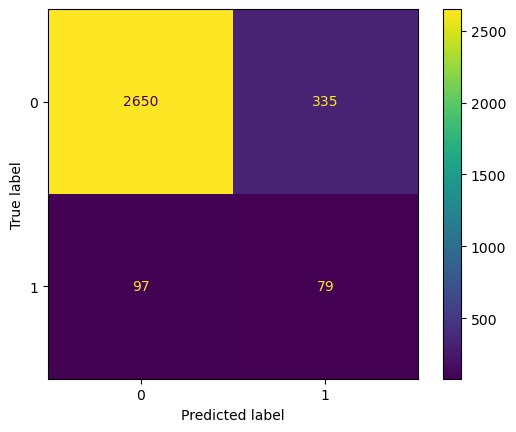

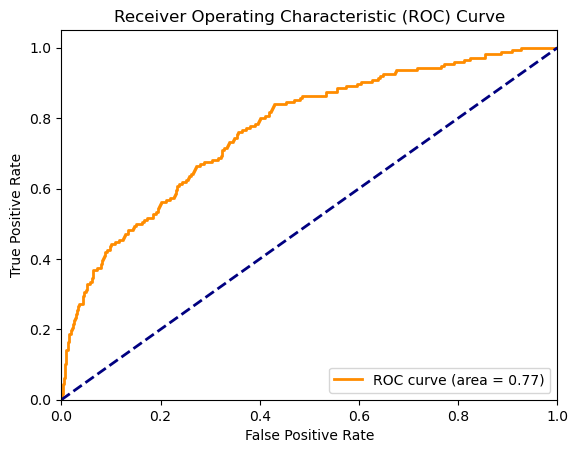

In [ ]:
# Evaluation of SMOTE
print("Accuracy:", accuracy_score(y_test, y_pred_ros))
print("Precision:", precision_score(y_test, y_pred_ros))
print("Recall:", recall_score(y_test, y_pred_ros))
print("F1 Score:", f1_score(y_test, y_pred_ros))
print("F2 Score:", fbeta_score(y_test, y_pred_ros, beta=2))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_ros))

# Print Classification Report
print(classification_report(y_test, y_pred_ros))

# For better visualisation
# 1. Plotting the Confusion Matrix
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ros)

# 2. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_ros)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
